# Imports

In [398]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
import sklearn as sk
import sklearn.neural_network as sknn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* https://www.kaggle.com/imdevskp/corona-virus-report for the COVID-19 dataset

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [399]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
30640,,Nepal,28.1667,84.2500,2020-05-16,291,1,36,254
32021,Isle of Man,United Kingdom,54.2361,-4.5481,2020-05-21,336,24,303,9
16191,,Bolivia,-16.2902,-63.5887,2020-03-23,27,0,0,27
3881,,Nicaragua,12.8654,-85.2072,2020-02-05,0,0,0,0
16224,Heilongjiang,China,47.8620,127.7615,2020-03-23,484,13,0,471
20277,,Italy,43.0000,12.0000,2020-04-07,135586,17127,24392,94067


## Population Dataset


In [400]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [401]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [402]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
25528,,Diamond Princess,0.0,0.0,2020-04-27,712,13,645,54
27648,,Diamond Princess,0.0,0.0,2020-05-05,712,13,645,54
24203,,Diamond Princess,0.0,0.0,2020-04-22,712,13,644,55
618,,Diamond Princess,0.0,0.0,2020-01-24,0,0,0,0
31786,,MS Zaandam,0.0,0.0,2020-05-20,9,2,0,7
18638,,Diamond Princess,0.0,0.0,2020-04-01,712,11,603,98


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [403]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [404]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [405]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

### Group by Country

In [406]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()
# full_grouped = full_table.groupby(['Country/Region','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0


### Adding population
In this section, we merge both datasets by Country/Region.

In [407]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])

full_grouped

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25
...,...,...,...,...,...,...,...,...,...,...,...
31995,Zimbabwe,-20.0,30.0,2020-05-21,51,4,18,29,14818157,38,38
31996,Zimbabwe,-20.0,30.0,2020-05-22,51,4,18,29,14818157,38,38
31997,Zimbabwe,-20.0,30.0,2020-05-23,56,4,18,34,14818157,38,38
31998,Zimbabwe,-20.0,30.0,2020-05-24,56,4,25,27,14818157,38,38


### World Data

In [408]:
world_data = full_grouped.groupby(['Date'])['Confirmed','Deaths','Recovered','Active','Population'].sum().reset_index()
world_data.loc[world_data['Date'] == world_data['Date'].max()]
world_data.head()

,Date,Confirmed,Deaths,Recovered,Active,Population
0,2020-01-22,555,17,28,510,51733396749
1,2020-01-23,654,18,30,606,51733396749
2,2020-01-24,941,26,35,880,51733396749
3,2020-01-25,1434,42,38,1354,51733396749
4,2020-01-26,2118,56,51,2011,51733396749


In [409]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              32000 non-null  object        
 1   Lat                         32000 non-null  float64       
 2   Long                        32000 non-null  float64       
 3   Date                        32000 non-null  datetime64[ns]
 4   Confirmed                   32000 non-null  int64         
 5   Deaths                      32000 non-null  int64         
 6   Recovered                   32000 non-null  int64         
 7   Active                      32000 non-null  int64         
 8   Population                  32000 non-null  int64         
 9   Population Density (P/Km²)  32000 non-null  int64         
 10  Urban Population %          32000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)


array([], dtype=object)

In [410]:
full_grouped.sample(6)

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
13619,Estonia,58.595300,25.013600,2020-05-20,1794,64,956,774,1326357,31,68
13721,Eswatini,-26.522500,31.465900,2020-04-27,65,1,10,54,1157707,67,30
31335,Venezuela,6.423800,-66.589700,2020-04-16,204,9,111,84,28451828,32,100
20062,Liechtenstein,47.140000,9.550000,2020-03-24,51,0,0,51,38106,238,15
19007,Kuwait,29.500000,47.750000,2020-01-29,0,0,0,0,4257495,240,100
31642,Yemen,15.552727,48.516388,2020-02-08,0,0,0,0,29687214,56,38


### Calculating Cases per Million of People




In [411]:

def calc_permillion(df):
    df['Confirmed per million'] = round((df['Confirmed'] / df['Population']) * 1000000)
    df['Deaths per million']    = round((df['Deaths'] / df['Population']) * 1000000)
    df['Recovered per million'] = round((df['Recovered'] / df['Population']) * 1000000)
    df['Active per million']    = round((df['Active'] / df['Population']) * 1000000)
    return df.iloc[:,[0,1,2,3,8,9,10,11,12,13,14]]
    # return df.iloc[:,[0,1,5,6,7,8,9,10,11,12]]


per_million = calc_permillion(full_grouped)

per_million.head()

,Country/Region,Lat,Long,Date,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0,65.0,2020-01-22,38742911,60,25,0.0,0.0,0.0,0.0
1,Afghanistan,33.0,65.0,2020-01-23,38742911,60,25,0.0,0.0,0.0,0.0
2,Afghanistan,33.0,65.0,2020-01-24,38742911,60,25,0.0,0.0,0.0,0.0
3,Afghanistan,33.0,65.0,2020-01-25,38742911,60,25,0.0,0.0,0.0,0.0
4,Afghanistan,33.0,65.0,2020-01-26,38742911,60,25,0.0,0.0,0.0,0.0


### Value Truncation

Since the COVID-19 dataset only has data from  22nd of January of 2020 onwards, we will define Date from here moving foward as days since the 22nd of January of 2020.

In [412]:
per_million['Date'].min()

Timestamp('2020-01-22 00:00:00')

This function does that:

In [413]:
def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,20).toordinal()

def revertdaysSince(d):
    return datetime(2020,1,20) + timedelta(days=d)

In [414]:
per_million['Date'] = per_million['Date'].map(daysSinceJan)

In [415]:
per_million =  per_million.sort_values(['Date','Country/Region'],ascending=[True, True])
per_million.head()

,Country/Region,Lat,Long,Date,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0000,65.0000,2,38742911,60,25,0.0,0.0,0.0,0.0
125,Albania,41.1533,20.1683,2,2878420,105,63,0.0,0.0,0.0,0.0
250,Algeria,28.0339,1.6596,2,43685618,18,73,0.0,0.0,0.0,0.0
375,Andorra,42.5063,1.5218,2,77240,164,88,0.0,0.0,0.0,0.0
500,Angola,-11.2027,17.8739,2,32644783,26,67,0.0,0.0,0.0,0.0


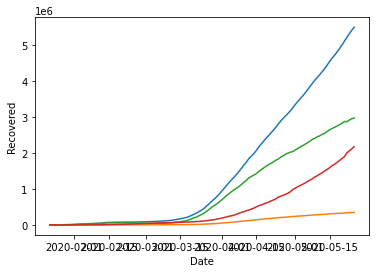

In [416]:
sb.lineplot(x='Date',y='Confirmed',data=world_data)
sb.lineplot(x='Date',y='Deaths',data=world_data)
sb.lineplot(x='Date',y='Active',data=world_data)
sb.lineplot(x='Date',y='Recovered',data=world_data)

In [417]:
per_million.head()

,Country/Region,Lat,Long,Date,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0000,65.0000,2,38742911,60,25,0.0,0.0,0.0,0.0
125,Albania,41.1533,20.1683,2,2878420,105,63,0.0,0.0,0.0,0.0
250,Algeria,28.0339,1.6596,2,43685618,18,73,0.0,0.0,0.0,0.0
375,Andorra,42.5063,1.5218,2,77240,164,88,0.0,0.0,0.0,0.0
500,Angola,-11.2027,17.8739,2,32644783,26,67,0.0,0.0,0.0,0.0


# Model Training

## Inputs and outputs

This function will return a pair of inputs and outputs given the country:

In [418]:
def world_train_data(df_full,country=None):
    df = df_full
    input  = ['Date','Population Density (P/Km²)','Urban Population %','Lat','Long']
    if country is not None:
        df = df_full.loc[ df_full['Country/Region'] == country]
        input = ['Date']
    return df[input], df[['Confirmed per million',	'Deaths per million',	'Recovered per million']]


In [419]:
# X,Y = world_train_data(per_million)

# X = X.values
# Y = Y.values


# nn = sknn.MLPRegressor(
#     hidden_layer_sizes=(20,50,20,100,20,50,20),
#     activation='relu',
#     solver='adam',
#     alpha=0.00001,
#     batch_size='auto',
#     max_iter = 100000,
#     n_iter_no_change=201,
#     verbose=True,
#     )

# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)


# nn.fit(X_train,y_train) # Train the model
# nn.score(X_test,y_test) # Calculate R² for the model


In [420]:
per_million.loc[per_million['Country/Region'] == 'Portugal']['Population Density (P/Km²)'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Urban Population %'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Long'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Lat'].unique()

array([39.3999])

In [421]:
def print_graph(world_viz, title):
    world_viz = world_viz.groupby(['Date']).sum().reset_index()
    things = ['Confirmed','Deaths','Recovered']
    dd = world_viz.melt(['Date'],var_name='C/D/R', value_name='Cases',value_vars=things)

    chart = sb.relplot(x='Date',y='Cases',hue='C/D/R',data=dd,kind='line').set(title = title)

    axs = chart.axes

    days = mdates.DayLocator(interval=9)
    months = mdates.MonthLocator()  # every month
    days_fmt = mdates.DateFormatter('%d-%b')

    for ax in axs[0]:
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(days_fmt)
        ax.xaxis.set_minor_locator(days)

        ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        ax.grid(True)


In [422]:


# ip = []
# for dat in range(0,125+30): # Predict from 0 to 155 days from January 1st 2020
#     ip.append([dat,111,66,39.3999,-8.2245]) # Hard Coded Pop Density, Urban Pop %, Latitude and Longitude

# out = nn.predict(ip)

# nl = []

# for i,o in zip(ip,out):
#     nl.append([*i,*o])

# predict = pd.DataFrame(nl,columns=['Date','Population Density (P/Km²)','Urban Population %','Lat','Long','Confirmed','Deaths','Recovered'])


# predict['Date'] = predict['Date'].map(revertdaysSince) 
# predict['Confirmed'] = predict['Confirmed'].map(lambda x: round((x/1000000) * 10202571))
# predict['Recovered'] = predict['Recovered'].map(lambda x: round((x/1000000) * 10202571))
# predict['Deaths'] = predict['Deaths'].map(lambda x: round((x/1000000) * 10202571) )


# print_graph(predict)
# print_graph(full_grouped.loc[full_grouped['Country/Region'] == 'Portugal'])


## SVM - Support Vector Machine

- For predicting the number of cases of Coronavirus, recovered patients, and deaths, we can develop a Support Vector Regression. This SVR would take in as input the Date, and output the mentioned parameters - Number of cases, recovered patients, and deaths. This data would refer to a specific country.
- In order to find the best parameters for the Regression at hand, we performed a grid search with a wide posssibility of values for different parameters (C, degree, epsilon, alpha). We also experimented with different kernels for the Regressor, and found different results for each one.

In [423]:
def print_prediction(fin, future_days=180):

    inp = [dat for dat in range(0,125 + future_days)]
    inp_arr = np.asarray(inp)

    fin = []
    for i,o in zip(inp, y_prediction):
        fin.append([i,*o])

    predict2 = pd.DataFrame(fin,columns=['Date','Confirmed','Deaths','Recovered'])
    pop = full_grouped.loc[full_grouped['Country/Region'] == country_svn]['Population'].max()

    predict2['Date'] = predict2['Date'].map(revertdaysSince) 
    predict2['Confirmed'] = predict2['Confirmed'].map(lambda x: round((x/1000000) * pop))
    predict2['Recovered'] = predict2['Recovered'].map(lambda x: round((x/1000000) * pop))
    predict2['Deaths'] = predict2['Deaths'].map(lambda x: round((x/1000000) * pop) )

    print_graph(predict2, "Prediction for " + str(future_days) + " days in " + country_svn)
    print_graph(full_grouped.loc[full_grouped['Country/Region'] == country_svn], "Real data for " + country_svn)

In [424]:
def make_prediction(country_svn, kernel, future_days=60):
    X,Y = world_train_data(per_million, country_svn)

    X_train, X_test, y_train, y_test = train_test_split(X.values,Y.values,test_size=0.20, shuffle=True)

    pipe_svr = Pipeline(
        [
            ("scl", StandardScaler()),
            ("reg", MultiOutputRegressor(SVR(kernel=kernel)))
        ]
    )

    grid_param_svr = {
    "reg__estimator__C": [0.1, 1, 10, 100, 1000, 10000],
    "reg__estimator__degree": [2,3,4,5,6,7],
    "reg__estimator__epsilon": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    "reg__estimator__gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    "reg__estimator__coef0": [1e-6, 1e-4, 1e-2, 1e-1, 0]
    }

    gs_svr = (
        GridSearchCV(
            estimator=pipe_svr,
            param_grid=grid_param_svr,
            cv=2,
            scoring = "neg_mean_squared_error",
            n_jobs = -1
            )
        )

    gs_svr = gs_svr.fit(X_train, y_train)
    gs_svr = gs_svr.best_estimator_

    inp = [dat for dat in range(0,125 + future_days)]
    inp_arr = np.asarray(inp)

    y_pred = gs_svr.predict(inp_arr.reshape(-1, 1))

    print(gs_svr.score(X_test, y_test))
    return y_pred

In [ ]:
def print_prediction_instance(kernels, future_days, countries):
    for kernel in kernels:
        for country_svn in countries:
            y_prediction = make_prediction(country_svn, kernel, future_days)
            print_prediction(y_prediction, future_days)

## Results

- We developed predictions for 3 different kernels: linear, polynomial and rbf. Since the virus is new and there is not a lot of data to be analysed, it it quite difficult to correctly predict the most accurate kernel to select, sice the tendency which the number of new cases, deaths and recovered patients is not knowk. The results were significantly different in each one.

- Exponential kernel

This kernel seems to be a good fit for the problem at hand, and is reaching very respectful scores. Since the growth of reported cases was exponential in the early weeks of the pandemic, the Regression developed by this kernel follows the same exponential tendency, which accounts for the good scores it reaches. However, if the number of cases continuies to drop or even stabilize, as it has in the past few weeks, this kernel may loose its relevancy for Covid-19 predictionss.

- Lineal kernel

The R^2 score shows that this kernel is not the most appropriate for the given problem. However, by analysing the line, we see that, if the number of Covid-19 are expected to have a linear growth in the coming times, which the most recent data seems to suggest, it may become a better solution and accomplish better scores. However, since the growth was exponential in the first few weeks of the pandemic, this kernel lacks in score. Nevertheless, we consider it to be a good fit for the problem since the number of reported cases has been generally dropping significantly in recent times.

- RBF kernel

This kernel seems to be the most indicated for Covid-19 cases predictions, at least as far as scores go. Reaching R^2 scores of close to 1, it seems to fit really well with the problem at hand. However, analysing the graphs, we see that it struggles to make predictions for the days in the future: the number of cases drop significantly whenever the Date taken as input surpasses the current day. We think that this is justified by the shortage in input Data for the regressor, since only the Date is being considered. In the future, we could expand into new data sets and solve this issue, as well as improving the predictions for all regressions.

In [425]:
countries = ["Portugal", "Sweden", "United States", "Singapore", "Spain", "Italy"]
kernels = ['poly', 'linear', 'rbf']
future_days = 90

print_prediction_instance(kernel, future_days)

0.7270258564798869
0.9302484689261825
0.9720553801083808
0.7053272590941964
0.9207192634487344
0.9325313013530706
0.5008601580987914
0.5595210894852335
0.6863242094230787
